# Logistic Regression with PyMC3

Recall we talked about linear regression, and usually had the assumtion that the response (or dependent) variable, y, was normally distributed with some parameter $\mu$ and $\sigma$. We called those approaches of modelling a linear relation as **simple/multiple linear regression**. 

**But..** what if the response variable is not normally distributed?

In such a case we use an approach called **generalized linear model (GLM)**.  <br>
**GLM** is a flexible generalization of ordinary linear regression that allows for response (or dependent) variables that have distribution models other than a normal distribution. Such generalization happens by allowing the linear model to be related to the response variable via a **link function**. <br>

In short, we can define a function (called link function) of the response (or dependent) variable that can be linearly modelled in terms of the explanatory (independent) variable(s).

## The recipe

- Pick a distribution for the response variable (commonly exponential distributions are used)
- Define a linear predictor
- Define the link function that links the linear predictor to the parameter(s) of the explanatory data distribution

In [146]:
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [164]:
def sigmoid(z, a=1, b=1):
    return a / (b + np.exp(z))

In [165]:
X = np.arange(-1, 1, .01)

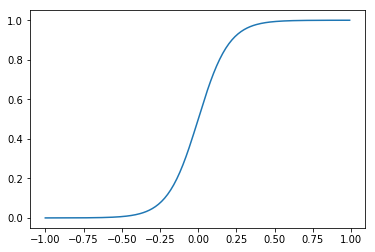

In [166]:
beta_0 = 0
beta_1 = -10
plt.plot(X, sigmoid(beta_0 + beta_1 * X));

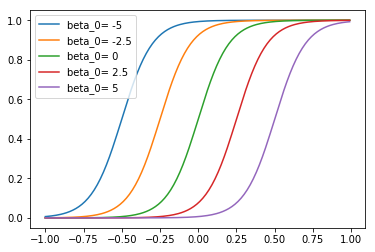

In [169]:
beta_1 = -10
for beta_0 in [-5, -2.5, 0, 2.5, 5]:
    plt.plot(X, sigmoid(beta_0 + beta_1 * X), label='beta_0= ' + str(beta_0));
    
plt.legend();

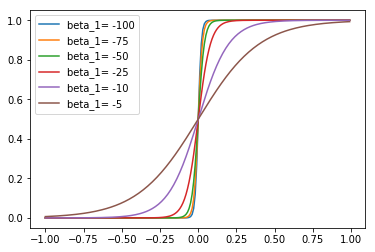

In [170]:
beta_0 = 0
for beta_1 in [-100, -75, -50, -25, -10, -5]:
    plt.plot(X, sigmoid(beta_0 + beta_1 * X), label='beta_1= ' + str(beta_1));
    
plt.legend();

In [196]:
def gen_data_lr(n, x_range, beta_0=None, beta_1=None, noise_std=None, binary_thresh=None):
    # generate parameter values randomly
    beta_0 = beta_0 if beta_0 else 0
    beta_1 = beta_1 if beta_1 else -10
    std = noise_std if noise_std else np.round(np.random.uniform(.5, 2), 1)
    
    X_vals, (X, Y) = np.arange(*x_range), np.zeros((2, n))
    for ind in range(n):
        X[ind] = sample(list(X_vals), 1)[0]
        y_mean = sigmoid(beta_0 + beta_1 * X[ind])
        if binary_thresh:
            y_mean = sigmoid(beta_0 + beta_1 * X_vals[-1]) if y_mean > binary_thresh else sigmoid(beta_0 + beta_1 * X_vals[0])

        Y[ind] = np.random.normal(loc=y_mean, scale=std) if noise_std else y_mean
        
    return X, Y, beta_0, beta_1, std

In [205]:
X, Y, beta_0, beta_1, std = gen_data_lr(n=10000, x_range=(-1, 1, .001), beta_0=0, beta_1=-20, noise_std=.01, binary_thresh=.5)

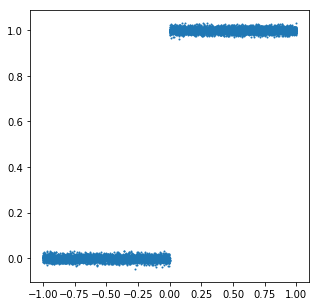

In [206]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X, Y, s=1);

## How can we model this data?

- on each level, it seems like the data is normally distributed, with a constant standard devation, and
- the mean of the data distribution, $\mu$, appears to have a step-like relationship with respect to the explanatory variable.

So..

- Data distribution: y ~ N(mu, std**2) <br>
- Linear Predictor: eeta = beta_0 + beta_1 * X
- Link function: mu = 1 / (1 + exp(-eetha))

What are the parameters of interest?
- mu
- std
- beta_0
- beta_1

How to implement it?
- define priors for the parameters of interest
- link the data to the data distribution paramters
- define the data distibution (or likelihood function), which links the paramters to the observed data

In [216]:
with pm.Model() as linreg_model:
    
    # define the priors
    beta_0 = pm.Normal('beta_0', mu=0, sd=1)
    beta_1 = pm.Normal('beta_1', mu=0, sd=1)
    std = pm.HalfNormal('std', sd=.01)
    
    # linear predictor
    eetha = beta_0 + beta_1 * X
    
    # link function
    mu = sigmoid(eetha)
    sd = std
    
    likelihood_dist = pm.Normal('likelihood_dist', mu=mu, sd=sd, observed=Y)

In [217]:
with linreg_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(10000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [std]
>Metropolis: [beta_1]
>Metropolis: [beta_0]
The number of effective samples is smaller than 10% for some parameters.


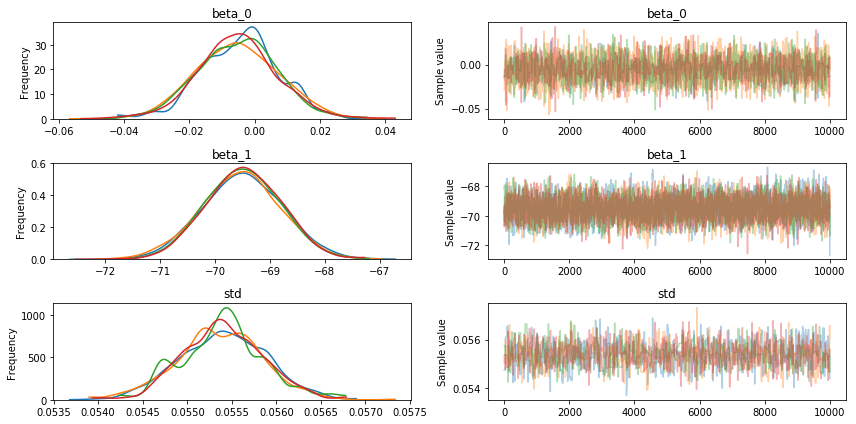

In [218]:
pm.traceplot(trace);

In [219]:
beta_0_estimated = trace['beta_0'].mean()
beta_1_estimated = trace['beta_1'].mean()
std_estimated = trace['std'].mean()
X_gen, Y_gen, beta_0, beta_1, std = gen_data_lr(n=1000, x_range=(-1, 1, .001), 
                                                beta_0=beta_0_estimated, 
                                                beta_1=beta_1_estimated, 
                                                noise_std=std_estimated)

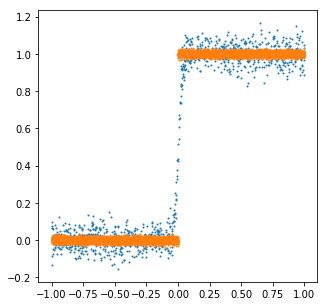

In [220]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_gen, Y_gen, s=1);
ax.scatter(X, Y, s=1);